In [1]:
SIMULATED_ = True
PLOT_FIGURE = True
SAVE_FIGURE = True
SAVE_VIDEO = True

In [2]:
## Imports
%matplotlib inline
import os
import cv2
import json

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.feature import peak_local_max

if SIMULATED_:
    from components.SimulatedRadar import SimulatedRadar
else:
    from components.RadarLoader import RadarLoader
    seq_name = "2019-09-16-12-52-12"
%run carrada_utils/scripts/set_path.py 'components/carrada_datasets/'


from brian2 import *

In [3]:
# Network params
INTENSITY_EXC = 1.0
INTENSITY_INH = -10.0
SIGMA_EXC = 0.9 # 5?
SIGMA_INH = 12.0

CONN_CUTOFF=120
TAU = 200 # ms
LOWER_VOLT_THRESH = -1.0
GRID_DISTANCE=100.0

# Input params
INPUT_WEIGHT = 0.1
DATA_FREQ_MULTIPLIER=2.0
TIME_BETWEEN_FRAMES = 100.0

# Simulation input params
NOISE_FACTOR = 0.1

# Input and network size
SIZE_X = 64
SIZE_Y = 64

# Evaluation params
CUTOFF_DIST_EVAL = 10.0
SIGMA_DIST_EVAL = 5.0

In [4]:
#device.reinit()
#device.activate()
#device.delete(force=True)
#set_device('cpp_standalone')#, build_on_run=False)    


In [5]:
LEN_DATA = 0
if SIMULATED_:
    sim_data_loader = SimulatedRadar(noise_factor=NOISE_FACTOR)
    spiking_data, spiking_indices = sim_data_loader.get_random_datastream_spiking_brian2(size_x=SIZE_X)
    ds = sim_data_loader.get_random_datastream()
    gt_paths = sim_data_loader.get_paths()
    LEN_DATA = len(ds)
    print(f"Simulation data is loaded. Total number of frames: {LEN_DATA}")
else:
    data_loader = RadarLoader(seq_name)
    raw_data, size_bf = data_loader.get_range_angle_stream_data(clip_and_normalize=True, resize=(SIZE_X,SIZE_X))
    raw_camera_data = data_loader.get_color_image_datastream(resize=(SIZE_X,SIZE_Y))
    spiking_data, spiking_indices = data_loader.get_spiking_ra_stream_differentiated_normalized_brian2(size_x=SIZE_X, time_bw_frames=TIME_BETWEEN_FRAMES, data_factor=DATA_FREQ_MULTIPLIER)
    dense_, sparse_, box_, sp_mp_, sp_mp_vis_ = data_loader.visualize_annotations(differentiated=True, size_bf=size_bf, size_x_=(SIZE_X, SIZE_Y))
    LEN_DATA = len(raw_data-1)
    print(f"CARRADA data is loaded. Total number of frames: {LEN_DATA}")



Simulation data is loaded. Total number of frames: 129


In [6]:
# np.save("raw_data.npy", np.asanyarray(raw_data))
# #np.save("raw_camera_data.npy", np.asanyarray(raw_camera_data))
# np.save("spiking_data.npy", np.asanyarray(spiking_data))
# np.save("spiking_indices.npy", np.asanyarray(spiking_indices))
# np.save("dense_.npy", np.asanyarray(dense_))
#raw_data = np.load("raw_data.npy")
#raw_camera_data = np.load("raw_camera_data.npy")
#spiking_data = np.load("spiking_data.npy")
#spiking_indices = np.load("spiking_indices.npy")
#dense_ = np.load("dense_.npy")

In [7]:
start_scope()
tau = TAU*ms

eqs = '''
dv/dt = -v/tau : 1
x : meter
y : meter
'''

N = SIZE_X*SIZE_Y
rows = SIZE_X
cols = SIZE_Y
# initialize the grid positions
grid_dist = GRID_DISTANCE*umeter
sigma_exc = SIGMA_EXC*grid_dist
sigma_inh = SIGMA_INH*grid_dist
intensity_exc = INTENSITY_EXC/(2*math.pi*SIGMA_EXC**2)
intensity_inh = INTENSITY_INH/(2*math.pi*SIGMA_INH**2)
conn_distance = CONN_CUTOFF*grid_dist
lower_volt_thresh = LOWER_VOLT_THRESH
G = NeuronGroup(N, eqs, threshold='v>1.0', reset='v = 0.0', method='exact')
G.x = '(i // rows) * grid_dist - rows/2.0 * grid_dist'
G.y = '(i % rows) * grid_dist - cols/2.0 * grid_dist'

# Synapses
S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(condition='(i!=j) and (sqrt((x_pre - x_post)**2 + (y_pre - y_post)**2) < conn_distance)')
# Weight varies with distance
S.w = '(intensity_exc*exprel(-((x_pre - x_post)**2 + (y_pre - y_post)**2)/(2*(sigma_exc**2))))'

S_inhib = Synapses(G, G, 'w : 1', on_pre='v_post = clip((w + v_post), lower_volt_thresh, inf)') # TODO: inf oder eins??
S_inhib.connect(condition='(i!=j) and (sqrt((x_pre - x_post)**2 + (y_pre - y_post)**2) < conn_distance)')
# Weight varies with distance
S_inhib.w =  '(intensity_inh*exprel(-((x_pre - x_post)**2 + (y_pre - y_post)**2)/(2*(sigma_inh**2))))'


G_input = SpikeGeneratorGroup(N, spiking_indices, spiking_data*ms)
weight=INPUT_WEIGHT# 0.1 works
S_input = Synapses(G_input, G, on_pre='v += weight')
S_input.connect(i='j')

M_spike = SpikeMonitor(G)
M_spike_input = SpikeMonitor(G_input)

print("Model built with:")
print(f"SIGMA_exc:{SIGMA_EXC} | SIGMA_inh:{SIGMA_INH}")
print(f"I_exc:{INTENSITY_EXC} | I_inh:{INTENSITY_INH}")
print(f"Tau: {TAU} | Lower_volt_thresh: {LOWER_VOLT_THRESH}")
if not SIMULATED_:
    print(f"Input_weight:{INPUT_WEIGHT} | data_freq_multiplier:{DATA_FREQ_MULTIPLIER}")
#M_state = StateMonitor(G, 'v', record=True)

Model built with:
SIGMA_exc:0.9 | SIGMA_inh:12.0
I_exc:1.0 | I_inh:-10.0
Tau: 200 | Lower_volt_thresh: -1.0


In [8]:
run((len(ds)-1)*TIME_BETWEEN_FRAMES*ms, report="stdout", report_period=30000*ms)


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'v_post = clip(w + v_post, lower_volt_thresh, inf)'
 [brian2.codegen.generators.base]


Starting simulation at t=0.0 for a duration of 12.8
3.1474 s (24%) simulated in 30s, estimated 1m 32s remaining.
6.36 s (49%) simulated in 1m 0s, estimated 1m 1s remaining.
9.6794 s (75%) simulated in 1m 30s, estimated 29s remaining.
12.8 s (100%) simulated in 1m 58s


In [9]:
# Prepare data
spike_times_plot = np.array(M_spike.t/ms)
spike_index_plot = np.array(M_spike.i)

input_spike_times_plot = np.array(M_spike_input.t/ms)
input_spike_index_plot = np.array(M_spike_input.i)

# Generate input and output spike maps, evaluate scores.
input_spike_map_data = []
output_spike_map_data = []
expected_response_map = []
if SIMULATED_:
    euclidian_dists = []
    expected_response_errs = []

for i in range(0,len(ds)):
    grid_input = np.zeros((SIZE_X,SIZE_X))
    grid_output = np.zeros((SIZE_X,SIZE_X))
    for ind_ in spike_index_plot[(i*100.0 < spike_times_plot) & (spike_times_plot < i*100.0+100.0)]:
        grid_output[ind_//SIZE_X][ind_%SIZE_X]+=1
    for ind_ in input_spike_index_plot[(i*100.0< input_spike_times_plot) & (input_spike_times_plot < i*100.0+100.0)]:
        grid_input[ind_//SIZE_X][ind_%SIZE_X]+=1
    
    input_spike_map_data.append((grid_input).copy())
    output_spike_map_data.append((grid_output).copy())
    
    if SIMULATED_:

        gt_path_points = gt_paths[:,i]
        # Find first peak in the output
        

        # Euclidian distance error
        max_err = 100.0
        if len(peak_local_max(grid_output, min_distance=10)) > 0:
            peak_coordinates = peak_local_max(grid_output, min_distance=10)[0]
            for it_ in gt_path_points:
                    dist = np.sqrt((it_[0] - peak_coordinates[0]) ** 2 + (it_[1] - peak_coordinates[1]) ** 2)
                    if dist < max_err:
                        max_err = dist
        euclidian_dists.append(max_err)

        # Expected response error only first one, add second later easily by creating another map
        j = gt_path_points[0][0] * SIZE_Y + gt_path_points[0][1]
        grid = np.empty((SIZE_X,SIZE_Y))
        for i in range(0,SIZE_X*SIZE_Y):
            dist = np.sqrt(
                    (i // SIZE_X - j // SIZE_X) ** 2 + (i % SIZE_Y - j % SIZE_Y) ** 2
                )
            if dist > CUTOFF_DIST_EVAL:
                transfer_func = 0
            else:
                transfer_func = ( (
                             np.exp(-dist**2 / (SIGMA_DIST_EVAL ** 2))
                        ) / (math.pi * 2 * (SIGMA_DIST_EVAL ** 2)))
            grid[i//SIZE_X][i%SIZE_Y] = transfer_func
        
        expected_response = np.array(grid / np.max(grid))
        expected_response_map.append(expected_response)
        if np.max(grid_output) != 0:
            actual_response = grid_output / np.max(grid_output)
            error_between_response = np.sum(np.absolute(expected_response - actual_response))
            expected_response_errs.append(error_between_response)
        else:
            expected_response_errs.append(np.sum(np.absolute(expected_response)))
    #else:
        # print("IMPLEMENT THIS!!!")
    


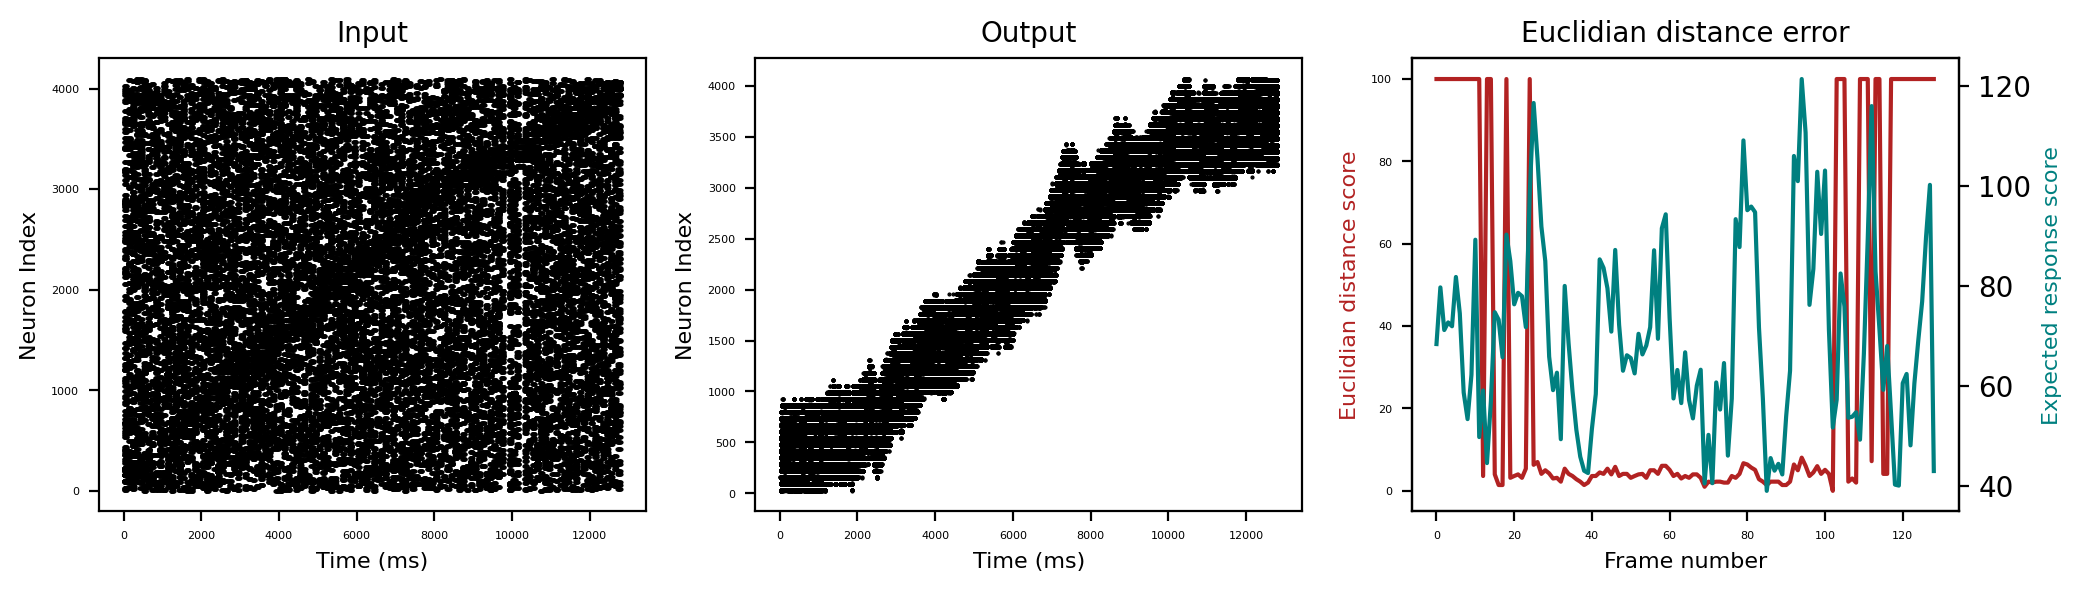

In [10]:
#210.0 in spikes_in.segments[0].spiketrains[37].times
fig2,(ax_1, ax_2, ax_3)= plt.subplots(1, 3, figsize=(12,3), dpi=200)

#ax_1.tick_params(axis='both',labelsize=8)
ax_1.set_title("Input", fontsize=10)
input_spike_train_plot = ax_1.plot(M_spike_input.t/ms, M_spike_input.i, '.k', ms=1)
ax_1.set_xlabel('Time (ms)', fontsize=8)
ax_1.set_ylabel('Neuron Index', fontsize=8)
ax_1.tick_params(axis='both',labelsize=4)

ax_2.set_title("Output",fontsize=10)
input_spike_train_plot = ax_2.plot(M_spike.t/ms, M_spike.i, '.k', ms=1)
ax_2.set_xlabel('Time (ms)',fontsize=8)
ax_2.set_ylabel('Neuron Index', fontsize=8)
ax_2.tick_params(axis='both',labelsize=4)

ax_3.set_title("Euclidian distance error",fontsize=10)
input_spike_train_plot = ax_3.plot(euclidian_dists, label="Evaluation Performance", color="firebrick")
ax_4 = ax_3.twinx()
input_spike_train_plot = ax_4.plot(expected_response_errs, label="Expected response error", color="teal")
ax_3.set_xlabel('Frame number',fontsize=8)
ax_3.set_ylabel('Euclidian distance score', fontsize=8, color="firebrick")
ax_4.set_ylabel('Expected response score', fontsize=8, color="teal")
ax_3.tick_params(axis='both',labelsize=4)

# ax_3.set_title("Expected Response diff",fontsize=10)
# input_spike_train_plot = ax_3.plot(expected_response_errs, label="Expected response error)
# ax_3.set_xlabel('Time (ms)',fontsize=8)
# ax_3.set_ylabel('Neuron Index', fontsize=8)
# ax_3.tick_params(axis='both',labelsize=4)
if SAVE_FIGURE:
    fig2.savefig(f"plots_sim_spike/sim_spike_eval_tau_{int(TAU)}_sExc_{int(10*SIGMA_EXC)}_sInh_{int(10*SIGMA_INH)}_inExc_{int(10*INTENSITY_EXC)}_inInh_{int(INTENSITY_INH)}.pdf")



In [11]:
if SIMULATED_:
    euclidian_error_mean = np.mean(euclidian_dists)
    expected_response_error_mean = np.mean(expected_response_errs)
    print(f"Euclidian error: {euclidian_error_mean}")
    print(f"Expected resp error: {expected_response_error_mean}")
    with open('sim_spike_performance.csv', 'a') as file:
        file.write(f'{euclidian_error_mean},{expected_response_error_mean},{SIGMA_EXC},{SIGMA_INH},{INTENSITY_EXC},{INTENSITY_INH}\n')


Euclidian error: 30.618499760792016
Expected resp error: 69.9719604758297


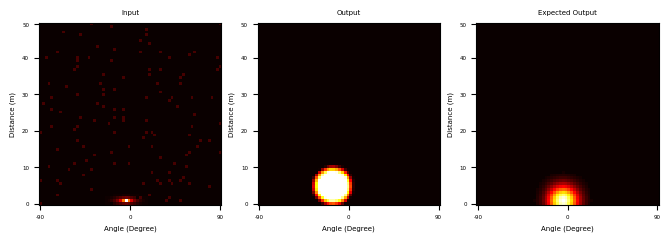

In [12]:
if SIMULATED_ and SAVE_VIDEO: 
    grid_input_mock = np.zeros((SIZE_X,SIZE_X))
    grid_output_mock = np.zeros((SIZE_X,SIZE_X))
    for ind_ in spike_index_plot[(0< spike_times_plot) & (spike_times_plot < 100.0)]:
        grid_output_mock[ind_//SIZE_X][ind_%SIZE_X]+=1
    for ind_ in input_spike_index_plot[(0 < input_spike_times_plot) & (input_spike_times_plot < 100.0)]:
        grid_input_mock[ind_//SIZE_X][ind_%SIZE_X]+=1


    fig,(ax1, ax2, ax3)= plt.subplots(1, 3, figsize=(8,5), dpi=100)

    # Input spikes
    ax1.tick_params(axis='both',labelsize=4)
    ax1.set_title("Input",fontsize=5)
    input_map = ax1.imshow(np.array(grid_input_mock), cmap='hot', interpolation='none')

    ax1.set_xticks([0, (SIZE_X-1)/2, SIZE_X-1])
    ax1.set_yticks([0,
                   SIZE_X*1/5-1,
                   SIZE_X*2/5-1,
                   SIZE_X*3/5-1,
                   SIZE_X*4/5-1,
                   SIZE_X-1])

    ax1.set_yticklabels([50, 40, 30, 20, 10, 0])
    ax1.set_xticklabels([-90, 0, 90])
    ax1.set_ylabel('Distance (m)', fontsize=5)
    ax1.set_xlabel('Angle (Degree)', fontsize=5)

    # Output neuron Spikes
    ax2.tick_params(axis='both',labelsize=4)
    ax2.set_title(f"Output",fontsize=5)

    output_map = ax2.imshow(np.array(grid_output_mock), cmap='hot', interpolation='none')

    ax2.set_xticks([0, (SIZE_X-1)/2, SIZE_X-1])
    ax2.set_yticks([0,
                   SIZE_X*1/5-1,
                   SIZE_X*2/5-1,
                   SIZE_X*3/5-1,
                   SIZE_X*4/5-1,
                   SIZE_X-1])
    ax2.set_yticklabels([50, 40, 30, 20, 10, 0])
    ax2.set_xticklabels([-90, 0, 90])
    ax2.set_ylabel('Distance (m)', fontsize=5)
    ax2.set_xlabel('Angle (Degree)', fontsize=5)
    
     # Expected output map
    ax3.tick_params(axis='both',labelsize=4)
    ax3.set_title(f"Expected Output",fontsize=5)

    expect_output_map = ax3.imshow(np.array(expected_response_map[0]), cmap='hot', interpolation='none')

    ax3.set_xticks([0, (SIZE_X-1)/2, SIZE_X-1])
    ax3.set_yticks([0,
                   SIZE_X*1/5-1,
                   SIZE_X*2/5-1,
                   SIZE_X*3/5-1,
                   SIZE_X*4/5-1,
                   SIZE_X-1])
    ax3.set_yticklabels([50, 40, 30, 20, 10, 0])
    ax3.set_xticklabels([-90, 0, 90])
    ax3.set_ylabel('Distance (m)', fontsize=5)
    ax3.set_xlabel('Angle (Degree)', fontsize=5)
    
    def init():
        input_map.set_data(np.array(input_spike_map_data[0]))
        output_map.set_data(np.array(output_spike_map_data[0]))
        expect_output_map.set_data(np.array(expected_response_map[0]))
        return [input_map, output_map, expect_output_map]


    # animation function.  This is called sequentially
    def animate(i):
        input_map.set_data(np.array(input_spike_map_data[i]))
        output_map.set_data(np.array(output_spike_map_data[i]))
        expect_output_map.set_data(np.array(expected_response_map[i]))
        return [input_map, output_map, expect_output_map]


    FFwriter = animation.FFMpegWriter(fps=10, extra_args=["-vcodec", "libx264"])
    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=len(ds)-1, interval=1, blit=True
    )

    anim.save(f"animations/sim_spike_eval_tau_{int(TAU)}_sExc_{int(10*SIGMA_EXC)}_sInh_{int(10*SIGMA_INH)}_inExc_{int(10*INTENSITY_EXC)}_inInh_{int(INTENSITY_INH)}_.mp4", FFwriter)
    



In [13]:
#if SIMULATED_ and SAVE_VIDEO: 
%matplotlib inline
import matplotlib
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 2**128
HTML(anim.to_jshtml())


In [14]:

device.delete(force=True)

